In [1]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
text="Hello my name is youngbo"
marked_text = "[CLS] " + text + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
print(tokenized_text)

['[CLS]', 'hello', 'my', 'name', 'is', 'young', '##bo', '[SEP]']


In [4]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
indexed_tokens

[101, 7592, 2026, 2171, 2003, 2402, 5092, 102]

In [5]:
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
hello         7,592
my            2,026
name          2,171
is            2,003
young         2,402
##bo          5,092
[SEP]           102


In [6]:
segments_ids = [1] * len(tokenized_text)
segments_ids

[1, 1, 1, 1, 1, 1, 1, 1]

In [7]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(

In [8]:
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)
#     hidden_states = outputs[2]

In [9]:
encoded_layers

[tensor([[[ 0.1545,  0.0195, -0.0786,  ..., -0.0880,  0.0727,  0.0560],
          [ 0.5052,  0.0383,  0.2937,  ..., -0.0753,  1.0579, -0.6632],
          [ 0.2731,  0.4624, -0.3089,  ..., -1.3637,  0.0340, -0.3090],
          ...,
          [-0.7341, -0.0807,  0.1923,  ..., -0.1601,  0.1035, -1.2278],
          [-0.7021,  0.1623,  0.3586,  ...,  0.0350, -0.0816,  0.5968],
          [ 0.2316, -0.0331,  0.0127,  ..., -0.0538,  1.0404,  0.1069]]]),
 tensor([[[ 0.0572, -0.1903, -0.1716,  ...,  0.0111,  0.1342,  0.0215],
          [ 0.6783,  0.4242,  0.8778,  ...,  0.3806,  1.0458, -1.0323],
          [ 0.2613,  0.4424,  0.0188,  ..., -1.2744,  0.2990, -0.6045],
          ...,
          [-0.6290,  0.3520,  0.4743,  ..., -0.3998,  0.2656, -1.7474],
          [-0.8426,  0.4608, -0.0417,  ...,  0.0709,  0.1479,  0.5743],
          [ 0.0574,  0.0451,  0.2252,  ...,  0.1441,  0.8292, -0.1336]]]),
 tensor([[[-0.0381, -0.0981,  0.0228,  ...,  0.1306,  0.0799,  0.1739],
          [ 0.6379,  0.6734,

In [10]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

# 8개의 개별 토큰(단어)이 768차원의 12개의 개별 벡터를 가짐 
print(encoded_layers[0].shape, encoded_layers[11].shape)

Number of layers: 12
Number of batches: 1
Number of tokens: 8
Number of hidden units: 768
torch.Size([1, 8, 768]) torch.Size([1, 8, 768])


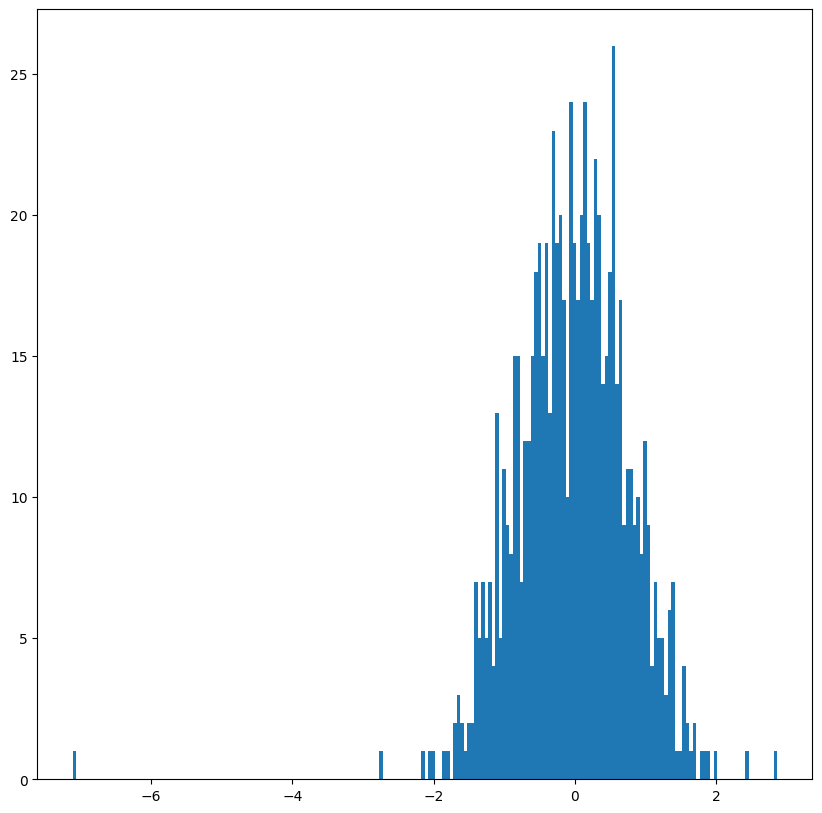

In [11]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [12]:
token_embeddings = torch.stack(encoded_layers, dim=0)

token_embeddings.size()



torch.Size([12, 1, 8, 768])

In [13]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([12, 8, 768])

In [14]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()# 8개의 개별 토큰(단어)이 768차원의 12개의 개별 벡터를 가짐 

torch.Size([8, 12, 768])

In [15]:
# Stores the token vectors, with shape [8 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [8 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 8 x 3072


In [16]:
# `encoded_layers` has shape [12 x 1 x 8 x 768]

# `token_vecs` is a tensor with shape [8 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 8 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [17]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


In [18]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 hello
2 my
3 name
4 is
5 young
6 ##bo
7 [SEP]
